In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [3]:
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

In [4]:
print(data.keys)
print(data['x'])

['x', 'edge_index']
tensor([[-1.],
        [ 0.],
        [ 1.]])


In [5]:
for key, item in data:
    print("{} found in data".format(key))

edge_index found in data
x found in data


In [6]:
#methods
(data.num_nodes, data.num_edges, data.num_node_features)

(3, 4, 1)

In [7]:
#more methods
data.contains_isolated_nodes()
data.contains_self_loops()
data.is_directed()

False

In [8]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
(len(dataset), dataset.num_classes, dataset.num_node_features)

(600, 6, 3)

In [9]:
(dataset.num_classes, dataset.num_node_features)

(6, 3)

In [10]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [12]:
model = Net()
data = dataset[0]
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [13]:
model.eval()

Net(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)

In [14]:
_, pred = model(data).max(dim=1)
correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / int(data.test_mask.sum())
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8110


In [15]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [20]:
data

Data(edge_index=[2, 156], train_mask=[34], x=[34, 34], y=[34])

In [16]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(edge_index=[2, 156], train_mask=[34], x=[34, 34], y=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


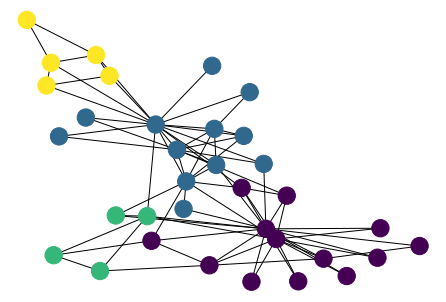

In [17]:
from torch_geometric.utils import to_networkx
import networkx as nx


G = to_networkx(data, to_undirected=True)
nx.draw(G,node_color=data.y)

In [18]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, 5)
        self.conv2 = GCNConv(5, 10)
        self.conv3 = GCNConv(10, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)
#34->4->4->2

GCN(
  (conv1): GCNConv(34, 5)
  (conv2): GCNConv(5, 10)
  (conv3): GCNConv(10, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


In [30]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')



Embedding shape: [34, 2]


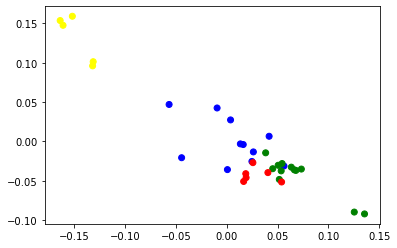

In [210]:
import matplotlib
a=data.y.detach().numpy()
b=h.detach().numpy()
colors=['blue','yellow','red','green']
plt.scatter(b[:,0],b[:,1],c=a, cmap=matplotlib.colors.ListedColormap(colors))

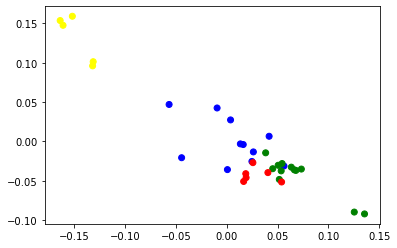

tensor(1.4095, grad_fn=<NllLossBackward>) 0


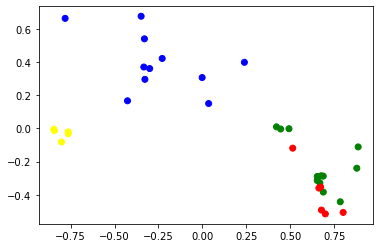

tensor(0.9721, grad_fn=<NllLossBackward>) 20


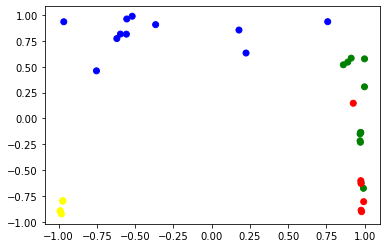

tensor(0.5367, grad_fn=<NllLossBackward>) 40


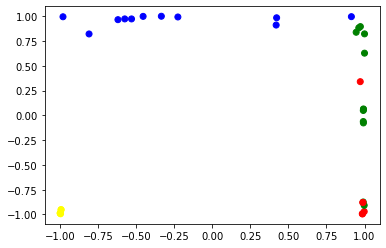

tensor(0.3256, grad_fn=<NllLossBackward>) 60


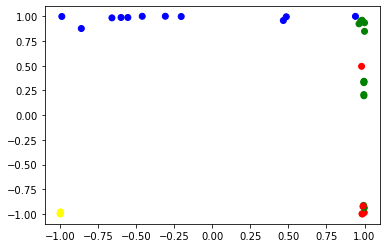

tensor(0.2275, grad_fn=<NllLossBackward>) 80


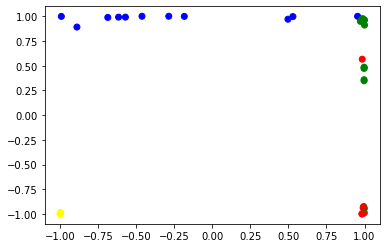

tensor(0.1720, grad_fn=<NllLossBackward>) 100


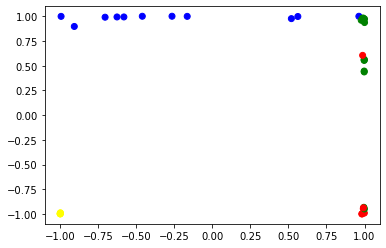

tensor(0.1368, grad_fn=<NllLossBackward>) 120


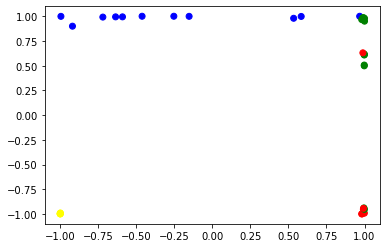

tensor(0.1124, grad_fn=<NllLossBackward>) 140


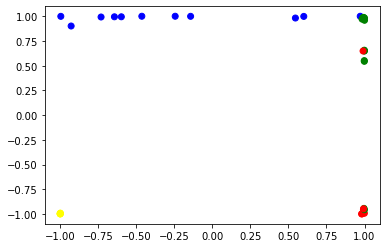

tensor(0.0946, grad_fn=<NllLossBackward>) 160


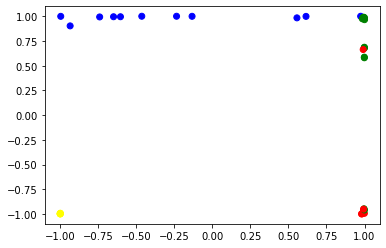

tensor(0.0811, grad_fn=<NllLossBackward>) 180


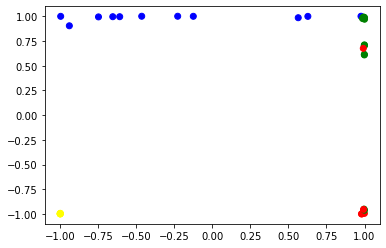

tensor(0.0705, grad_fn=<NllLossBackward>) 200


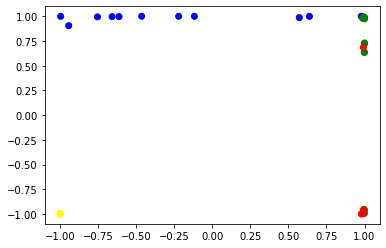

tensor(0.0620, grad_fn=<NllLossBackward>) 220


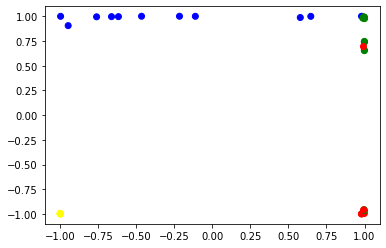

tensor(0.0551, grad_fn=<NllLossBackward>) 240


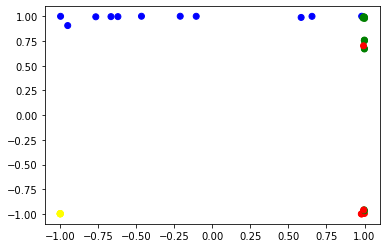

tensor(0.0493, grad_fn=<NllLossBackward>) 260


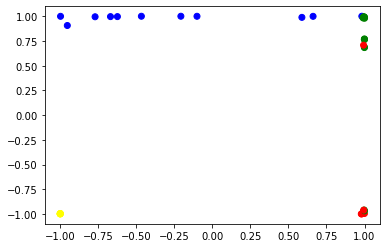

tensor(0.0445, grad_fn=<NllLossBackward>) 280


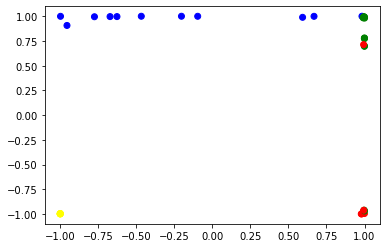

tensor(0.0404, grad_fn=<NllLossBackward>) 300


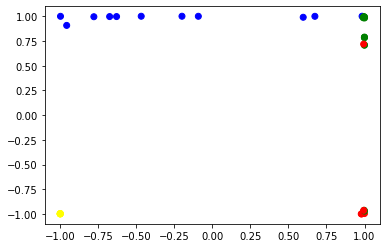

tensor(0.0369, grad_fn=<NllLossBackward>) 320


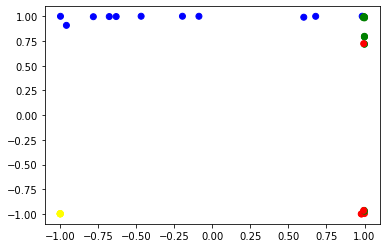

tensor(0.0338, grad_fn=<NllLossBackward>) 340


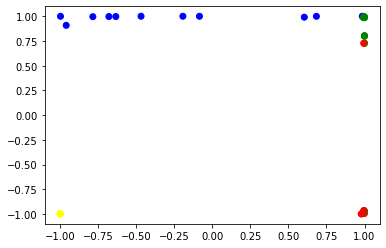

tensor(0.0311, grad_fn=<NllLossBackward>) 360


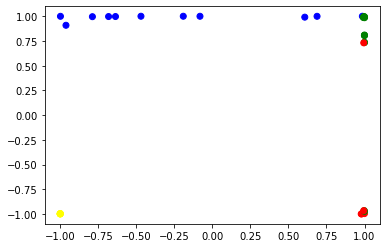

tensor(0.0288, grad_fn=<NllLossBackward>) 380


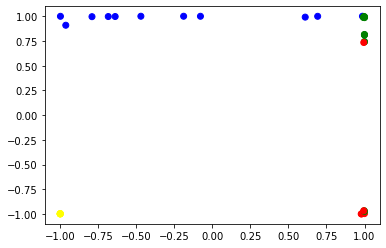

tensor(0.0267, grad_fn=<NllLossBackward>) 400


In [211]:
import time
a=data.y.detach().numpy()
model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    if epoch % 20 == 0:
        b=h.detach().numpy()
        plt.scatter(b[:,0],b[:,1],c=a, cmap=matplotlib.colors.ListedColormap(colors))
        plt.show()
        print(loss,epoch)
        time.sleep(0.3)

In [1]:
d,q=model(data.x, data.edge_index)
pred=d.max(axis=1)[1]

test_acc = torch.eq(pred, data.y).sum().float() / len(pred)
test_acc
#(pred,data.y)

NameError: name 'model' is not defined

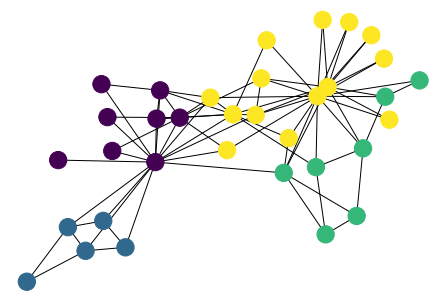

In [214]:

nx.draw(G,node_color=pred)


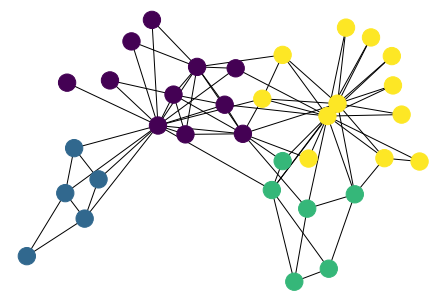

In [215]:
nx.draw(G,node_color=data.y)